# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

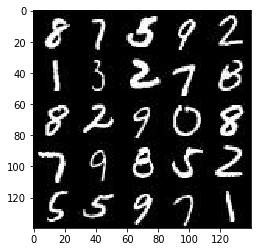

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

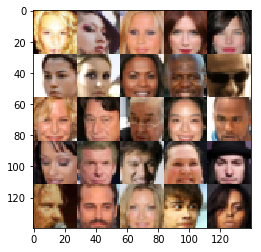

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def lrelu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d(layer, 64, 5, strides=1, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d(layer, 128, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d(layer, 128, 3, strides=1, padding='same')
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = lrelu(layer)
                
        s = layer.get_shape()
        flat_size = int(s[1] * s[2] * s[3])
        flat = tf.reshape(layer, [-1, flat_size])
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*128)
        layer = tf.reshape(layer, [-1, 7, 7, 128])
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d_transpose(layer, 128, 3, strides=1, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d_transpose(layer, 64, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d_transpose(layer, 64, 5, strides=1, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = lrelu(layer)
        
        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.tanh(layer)
    
    return layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    
    d_real, d_real_logits = discriminator(input_real)
    d_fake, d_fake_logits = discriminator(g_model, reuse=True)
        
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_real_loss + d_fake_loss
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    tr_vars = tf.trainable_variables()
    d_vars = [v for v in tr_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in tr_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt_op, g_opt_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    num_channels = len(data_image_mode)
    images, z, lr = model_inputs(data_shape[1], data_shape[2], num_channels, z_dim)
    d_loss, g_loss = model_loss(images, z, num_channels)
    d_opt_op, g_opt_op = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {images: batch_images, z: batch_z, lr: learning_rate}
                
                _ = sess.run(g_opt_op, feed_dict=feed_dict)
                _ = sess.run(d_opt_op, feed_dict=feed_dict)
            
                if steps % print_every == 0:
                    val_d_loss = sess.run(d_loss, feed_dict)
                    val_g_loss = sess.run(g_loss, feed_dict)

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(val_d_loss),
                          "Generator Loss: {:.4f}".format(val_g_loss))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 16, z, num_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1120... Generator Loss: 11.4937
Epoch 1/2... Discriminator Loss: 0.0203... Generator Loss: 4.6403
Epoch 1/2... Discriminator Loss: 0.0252... Generator Loss: 4.5785
Epoch 1/2... Discriminator Loss: 0.0189... Generator Loss: 4.8209
Epoch 1/2... Discriminator Loss: 0.0126... Generator Loss: 5.3529
Epoch 1/2... Discriminator Loss: 5.8371... Generator Loss: 0.1295
Epoch 1/2... Discriminator Loss: 0.0704... Generator Loss: 3.7446
Epoch 1/2... Discriminator Loss: 0.0511... Generator Loss: 4.3122
Epoch 1/2... Discriminator Loss: 0.0210... Generator Loss: 4.7569
Epoch 1/2... Discriminator Loss: 0.0150... Generator Loss: 5.0770


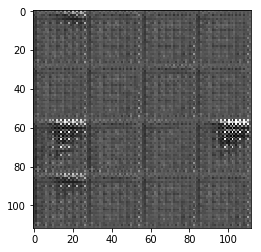

Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 12.3920
Epoch 1/2... Discriminator Loss: 0.0980... Generator Loss: 3.8475
Epoch 1/2... Discriminator Loss: 0.0327... Generator Loss: 4.1854
Epoch 1/2... Discriminator Loss: 0.0311... Generator Loss: 4.5535
Epoch 1/2... Discriminator Loss: 0.0262... Generator Loss: 4.2992
Epoch 1/2... Discriminator Loss: 0.0151... Generator Loss: 5.0263
Epoch 1/2... Discriminator Loss: 0.0212... Generator Loss: 4.5126
Epoch 1/2... Discriminator Loss: 0.0053... Generator Loss: 5.7971
Epoch 1/2... Discriminator Loss: 0.2537... Generator Loss: 2.5425
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.4911


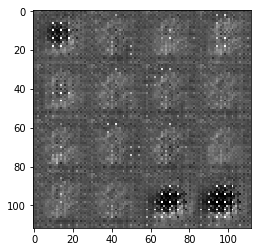

Epoch 1/2... Discriminator Loss: 1.5338... Generator Loss: 4.3389
Epoch 1/2... Discriminator Loss: 0.2175... Generator Loss: 3.3088
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 8.8874
Epoch 1/2... Discriminator Loss: 0.1023... Generator Loss: 3.0201
Epoch 1/2... Discriminator Loss: 0.0753... Generator Loss: 5.5183
Epoch 1/2... Discriminator Loss: 0.0739... Generator Loss: 3.6089
Epoch 1/2... Discriminator Loss: 0.0537... Generator Loss: 6.9913
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.0325
Epoch 1/2... Discriminator Loss: 0.4756... Generator Loss: 4.6790
Epoch 1/2... Discriminator Loss: 0.1890... Generator Loss: 2.2250


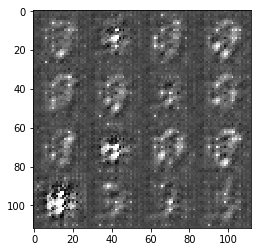

Epoch 1/2... Discriminator Loss: 0.5511... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 0.1675... Generator Loss: 2.4749
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 6.1910
Epoch 1/2... Discriminator Loss: 0.1335... Generator Loss: 2.9917
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 0.4772... Generator Loss: 1.3430
Epoch 1/2... Discriminator Loss: 0.1127... Generator Loss: 3.3095
Epoch 1/2... Discriminator Loss: 2.3764... Generator Loss: 4.8929


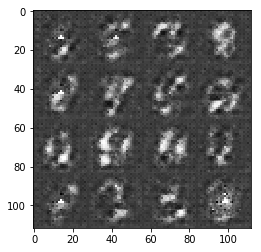

Epoch 1/2... Discriminator Loss: 3.5312... Generator Loss: 5.4345
Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 3.3812
Epoch 1/2... Discriminator Loss: 0.0937... Generator Loss: 3.4682
Epoch 1/2... Discriminator Loss: 0.0952... Generator Loss: 3.5803
Epoch 1/2... Discriminator Loss: 0.0466... Generator Loss: 4.0277
Epoch 1/2... Discriminator Loss: 4.9573... Generator Loss: 7.8720
Epoch 2/2... Discriminator Loss: 2.2409... Generator Loss: 4.6025
Epoch 2/2... Discriminator Loss: 0.4160... Generator Loss: 3.6782
Epoch 2/2... Discriminator Loss: 0.1955... Generator Loss: 3.3876
Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 4.2175


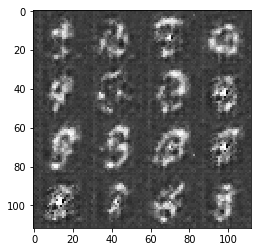

Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 4.7294
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 4.2805
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 4.0714
Epoch 2/2... Discriminator Loss: 0.1649... Generator Loss: 2.8841
Epoch 2/2... Discriminator Loss: 0.3754... Generator Loss: 4.2650
Epoch 2/2... Discriminator Loss: 0.0244... Generator Loss: 4.6647
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 5.0347
Epoch 2/2... Discriminator Loss: 1.8963... Generator Loss: 4.1306
Epoch 2/2... Discriminator Loss: 0.4353... Generator Loss: 3.8684
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 3.3676


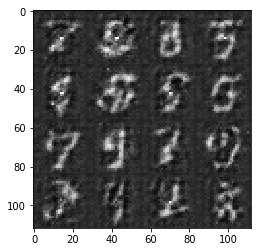

Epoch 2/2... Discriminator Loss: 0.3180... Generator Loss: 1.8185
Epoch 2/2... Discriminator Loss: 0.0638... Generator Loss: 3.5988
Epoch 2/2... Discriminator Loss: 0.0594... Generator Loss: 3.7525
Epoch 2/2... Discriminator Loss: 0.1794... Generator Loss: 5.0999
Epoch 2/2... Discriminator Loss: 0.0263... Generator Loss: 4.4599
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 3.9347
Epoch 2/2... Discriminator Loss: 2.1634... Generator Loss: 2.8157
Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 2.5029
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 3.4876
Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 3.0825


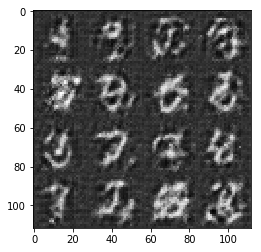

Epoch 2/2... Discriminator Loss: 1.4664... Generator Loss: 3.7976
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 3.1849
Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 3.8720
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 3.2137
Epoch 2/2... Discriminator Loss: 0.1106... Generator Loss: 3.1882
Epoch 2/2... Discriminator Loss: 0.1221... Generator Loss: 4.0484
Epoch 2/2... Discriminator Loss: 0.0580... Generator Loss: 3.9092
Epoch 2/2... Discriminator Loss: 0.0267... Generator Loss: 4.4610
Epoch 2/2... Discriminator Loss: 2.1868... Generator Loss: 5.5630
Epoch 2/2... Discriminator Loss: 0.1500... Generator Loss: 3.9362


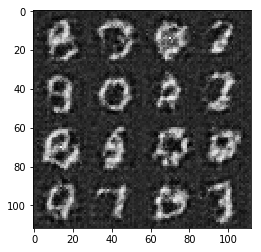

Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 2.0239
Epoch 2/2... Discriminator Loss: 0.0954... Generator Loss: 3.3927
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.4732
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.6063
Epoch 2/2... Discriminator Loss: 0.1518... Generator Loss: 2.7620
Epoch 2/2... Discriminator Loss: 0.1087... Generator Loss: 3.1672
Epoch 2/2... Discriminator Loss: 0.0477... Generator Loss: 3.9367
Epoch 2/2... Discriminator Loss: 0.0337... Generator Loss: 4.8483
Epoch 2/2... Discriminator Loss: 0.0133... Generator Loss: 5.7146
Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 3.9921


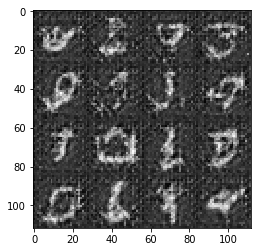

Epoch 2/2... Discriminator Loss: 0.0140... Generator Loss: 5.8074
Epoch 2/2... Discriminator Loss: 0.0131... Generator Loss: 5.9124
Epoch 2/2... Discriminator Loss: 0.0136... Generator Loss: 5.2382


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.02


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 3.0238... Generator Loss: 13.9000
Epoch 1/2... Discriminator Loss: 0.0154... Generator Loss: 5.1737
Epoch 1/2... Discriminator Loss: 0.0593... Generator Loss: 3.3151
Epoch 1/2... Discriminator Loss: 0.1119... Generator Loss: 5.2191
Epoch 1/2... Discriminator Loss: 0.0354... Generator Loss: 3.6469
Epoch 1/2... Discriminator Loss: 0.0211... Generator Loss: 5.0598
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 2.8343
Epoch 1/2... Discriminator Loss: 0.1451... Generator Loss: 2.9550
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 4.9791
Epoch 1/2... Discriminator Loss: 0.8982... Generator Loss: 4.1614


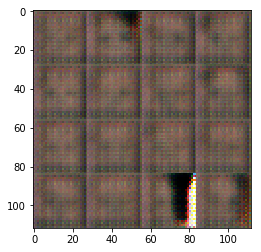

Epoch 1/2... Discriminator Loss: 2.7815... Generator Loss: 4.3100
Epoch 1/2... Discriminator Loss: 0.2290... Generator Loss: 2.1842
Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 1.8706
Epoch 1/2... Discriminator Loss: 0.1091... Generator Loss: 2.7286
Epoch 1/2... Discriminator Loss: 0.2675... Generator Loss: 3.9621
Epoch 1/2... Discriminator Loss: 6.4750... Generator Loss: 7.2181
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 3.4910
Epoch 1/2... Discriminator Loss: 2.3596... Generator Loss: 5.7132
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 4.0189
Epoch 1/2... Discriminator Loss: 0.1673... Generator Loss: 2.2763


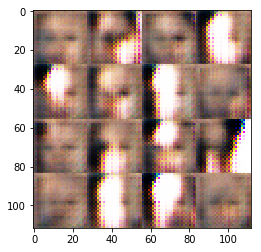

Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 1.9526
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 0.9305
Epoch 1/2... Discriminator Loss: 0.2996... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 0.2825... Generator Loss: 2.5310
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 1.3306
Epoch 1/2... Discriminator Loss: 0.2821... Generator Loss: 1.7509
Epoch 1/2... Discriminator Loss: 0.1833... Generator Loss: 4.5511
Epoch 1/2... Discriminator Loss: 6.0896... Generator Loss: 7.7885
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 2.9518
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 2.8642


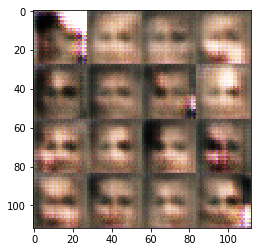

Epoch 1/2... Discriminator Loss: 0.2172... Generator Loss: 2.0595
Epoch 1/2... Discriminator Loss: 0.4136... Generator Loss: 1.3764
Epoch 1/2... Discriminator Loss: 0.1297... Generator Loss: 2.7769
Epoch 1/2... Discriminator Loss: 0.1111... Generator Loss: 2.5623
Epoch 1/2... Discriminator Loss: 2.6171... Generator Loss: 4.0133
Epoch 1/2... Discriminator Loss: 0.2850... Generator Loss: 2.9068
Epoch 1/2... Discriminator Loss: 0.2904... Generator Loss: 1.6712
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 0.0790... Generator Loss: 3.0709
Epoch 1/2... Discriminator Loss: 0.0848... Generator Loss: 2.9974


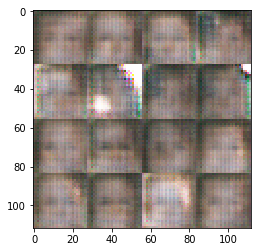

Epoch 1/2... Discriminator Loss: 0.7877... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 1.6334
Epoch 1/2... Discriminator Loss: 0.2795... Generator Loss: 2.7852
Epoch 1/2... Discriminator Loss: 0.0666... Generator Loss: 3.2065
Epoch 1/2... Discriminator Loss: 2.1591... Generator Loss: 4.7692
Epoch 1/2... Discriminator Loss: 3.5298... Generator Loss: 5.7193
Epoch 1/2... Discriminator Loss: 3.8629... Generator Loss: 4.1677
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 1.5598
Epoch 1/2... Discriminator Loss: 0.3281... Generator Loss: 1.5617
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 1.5880


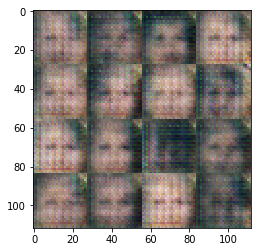

Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 4.0592
Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 2.7279
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 3.1259
Epoch 1/2... Discriminator Loss: 0.5000... Generator Loss: 2.9148
Epoch 1/2... Discriminator Loss: 0.6617... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 3.0577
Epoch 1/2... Discriminator Loss: 0.1278... Generator Loss: 3.1494
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 1.0858


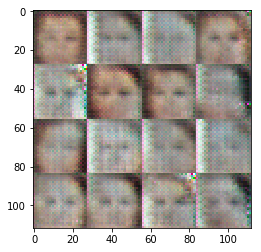

Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 6.1076
Epoch 1/2... Discriminator Loss: 0.0708... Generator Loss: 3.0284
Epoch 1/2... Discriminator Loss: 2.5581... Generator Loss: 3.3748
Epoch 1/2... Discriminator Loss: 0.0774... Generator Loss: 3.0594
Epoch 1/2... Discriminator Loss: 0.0773... Generator Loss: 3.0560
Epoch 1/2... Discriminator Loss: 3.6908... Generator Loss: 3.5199
Epoch 1/2... Discriminator Loss: 0.0580... Generator Loss: 3.4435
Epoch 1/2... Discriminator Loss: 2.4349... Generator Loss: 3.0048
Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 3.6637
Epoch 1/2... Discriminator Loss: 2.0480... Generator Loss: 1.5651


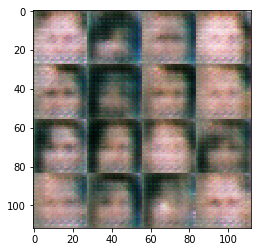

Epoch 1/2... Discriminator Loss: 1.5607... Generator Loss: 1.6391
Epoch 1/2... Discriminator Loss: 1.7168... Generator Loss: 2.6369
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 4.1082
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 3.1744
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 1.1868
Epoch 1/2... Discriminator Loss: 1.7922... Generator Loss: 2.8631
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 2.3908
Epoch 1/2... Discriminator Loss: 0.4388... Generator Loss: 1.7906


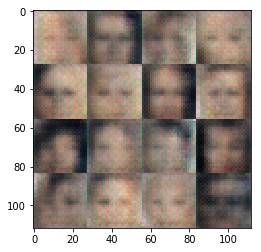

Epoch 1/2... Discriminator Loss: 0.1522... Generator Loss: 2.4970
Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 2.3838
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 2.2559
Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.9706
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: 0.8836... Generator Loss: 1.0863
Epoch 1/2... Discriminator Loss: 1.6288... Generator Loss: 2.4709
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.8289


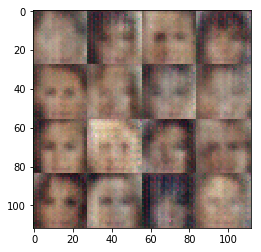

Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.7837
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 2.2468
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 2.2030
Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 1.7531
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 2.0457
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 1.8963
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 2.6211
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 1.5036


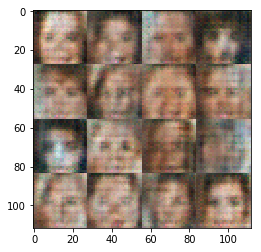

Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 1.7341
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 1.2093
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.6494


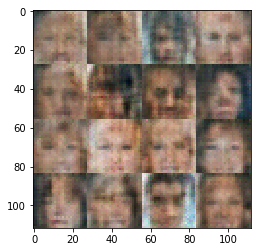

Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.0394... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 0.7037


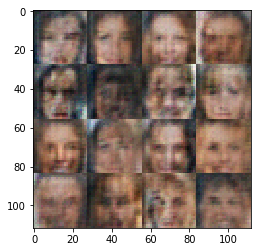

Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.6839
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.6099


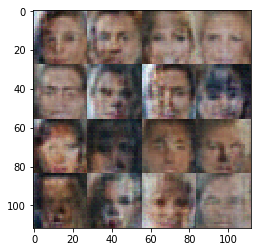

Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.0380
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 1.3548
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 1.4854


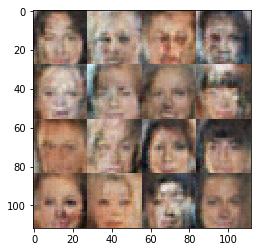

Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.5520
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 0.5658


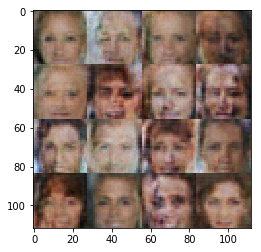

Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 1.4003
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 1.5567
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.8341


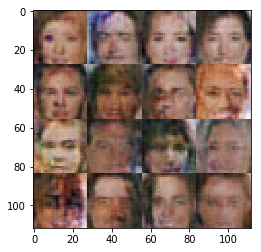

Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 1.1061
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 1.2625
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 1.2282
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.5552
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 1.4055
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 1.2876
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 1.3240


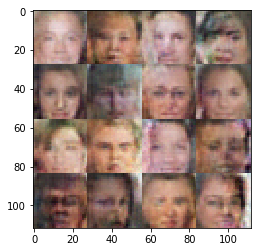

Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 1.1897
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 1.3649
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 1.2569
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 1.1165


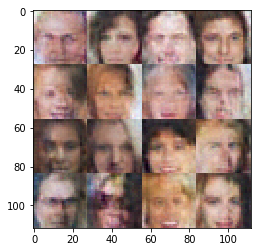

Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 1.3109
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.6732
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 1.1204
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 1.2683


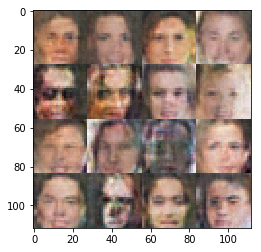

Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 1.2216
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 1.7028
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 1.3807
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 1.2868
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.9172


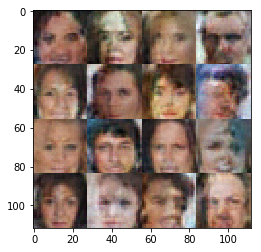

Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 1.5182
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 1.4359
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 1.5597
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 1.3360
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.7948


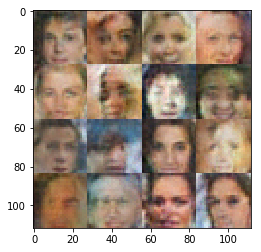

Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 1.5817
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.6601
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.7331


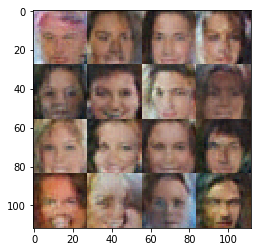

Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 0.8702
Epoch 2/2... Discriminator Loss: 1.5853... Generator Loss: 1.6994
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 1.3848


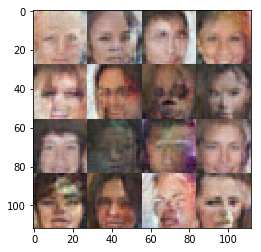

Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 1.2085
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.6265
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 1.5155
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 1.0617


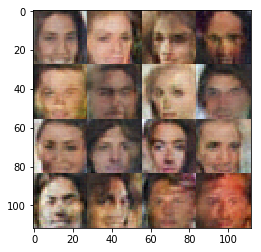

Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 1.0315
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.9118
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.6551


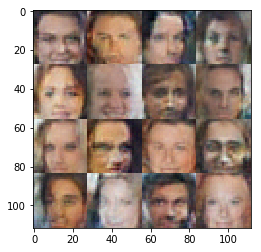

Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 1.1873... Generator Loss: 1.1597
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 1.7635
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 1.3235
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.5560
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.9396


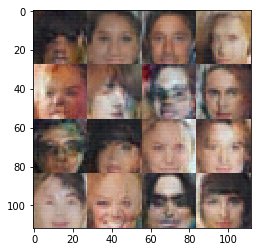

Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 1.2913
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 1.2049
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 1.1160


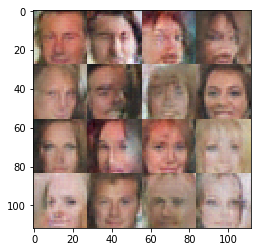

Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 1.4575
Epoch 2/2... Discriminator Loss: 1.1619... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 1.1415
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 1.1951... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 1.2057


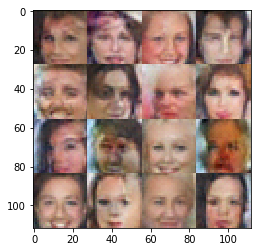

Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.9927
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 1.0001


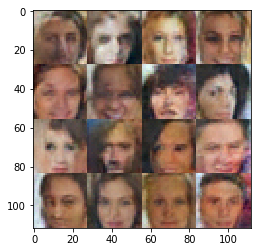

Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 1.3288
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 1.1631
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 1.2939
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.6700


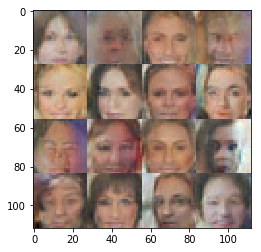

Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.1916... Generator Loss: 1.1895
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.6669
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.6616


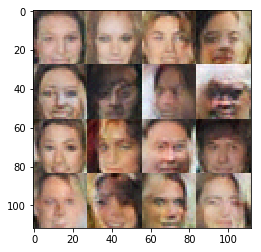

Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 1.2457


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.02


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.